In [29]:
# Change this to match your folder name in Drive
#PUT PATH OF UNZIPPED DATASET FOLDER WHICH EXISTS IN DATASET FOLDER ITSELF
DATASET_ROOT = "/content/drive/MyDrive/dataset/dataset"



In [30]:
import os
import json
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from tqdm import tqdm
import wandb


In [31]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.inputs_dir = os.path.join(root_dir, "inputs")
        self.outputs_dir = os.path.join(root_dir, "outputs")
        self.transform = transform
        self.augment = augment

        # Load mapping file
        json_path = os.path.join(root_dir, "data.json")
        with open(json_path, "r") as f:
            self.mapping = json.load(f)

        # Fixed RGB color mapping (0-1 range for tensors)
        self.color_map = {
            "red": [1.0, 0.0, 0.0],
            "green": [0.0, 1.0, 0.0],
            "blue": [0.0, 0.0, 1.0],
            "yellow": [1.0, 1.0, 0.0],
            "cyan": [0.0, 1.0, 1.0],
            "magenta": [1.0, 0.0, 1.0],
            "purple": [0.5, 0.0, 0.5],
            "orange": [1.0, 0.5, 0.0]
        }

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        item = self.mapping[idx]

        # Load polygon input and target output image
        input_img = Image.open(os.path.join(self.inputs_dir, item["input_polygon"])).convert("RGB").copy()
        target_img = Image.open(os.path.join(self.outputs_dir, item["output_image"])).convert("RGB").copy()

        # Create binary mask from input polygon
        mask_img = input_img.convert("L")  # grayscale
        mask_tensor = TF.to_tensor(mask_img)
        mask_tensor = torch.where(mask_tensor > 0.5, 1.0, 0.0)  # binary mask

        # Paired augmentations
        if self.augment:
            if random.random() > 0.5:
                input_img = TF.hflip(input_img)
                target_img = TF.hflip(target_img)
                mask_tensor = TF.hflip(mask_tensor)
            if random.random() > 0.5:
                input_img = TF.vflip(input_img)
                target_img = TF.vflip(target_img)
                mask_tensor = TF.vflip(mask_tensor)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                input_img = TF.rotate(input_img, angle)
                target_img = TF.rotate(target_img, angle)
                mask_tensor = TF.rotate(mask_tensor, angle)

        # Transform input and output (e.g., Resize, Normalize)
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        # Generate color RGB tensor
        color_name = item["colour"].lower()
        color_rgb = torch.tensor(self.color_map[color_name], dtype=torch.float32)  # shape: (3,)
        color_img = color_rgb.view(3, 1, 1).expand(3, input_img.shape[1], input_img.shape[2])  # shape: (3, H, W)

        # Combine original image with color image to make 6-channel input
        combined_input = torch.cat([input_img, color_img], dim=0)

        return combined_input, mask_tensor, target_img


In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            x = self.ups[idx + 1](torch.cat((skip_connection, x), dim=1))

        return self.sigmoid(self.final_conv(x))


In [33]:
def train_model(model, train_loader, val_loader, device, epochs=50):
    wandb.init(project="polygon-coloring")

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, masks, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, masks, targets = inputs.to(device), masks.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ensure mask has same shape as outputs
            if masks.ndim == 3:  # [B, H, W]
                masks = masks.unsqueeze(1)  # [B, 1, H, W]
            masks = masks.expand_as(outputs)  # [B, 3, H, W]

            # Masked L1 loss: only compute inside shape
            loss = torch.mean(torch.abs(outputs - targets) * masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks, targets in val_loader:
                inputs, masks, targets = inputs.to(device), masks.to(device), targets.to(device)

                outputs = model(inputs)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.expand_as(outputs)

                loss = torch.mean(torch.abs(outputs - targets) * masks)
                val_loss += loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        wandb.log({"Train Loss": avg_train_loss, "Validation Loss": avg_val_loss})
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

    wandb.finish()


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = PolygonColorDataset(f"{DATASET_ROOT}/training", transform=transform, augment=True)
val_dataset = PolygonColorDataset(f"{DATASET_ROOT}/validation", transform=transform, augment=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

model = UNet(in_channels=6, out_channels=3).to(device)
train_model(model, train_loader, val_loader, device, epochs=50)


Epoch 1/50: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 1: Train Loss=0.4378, Val Loss=0.4720


Epoch 2/50: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch 2: Train Loss=0.4020, Val Loss=0.4555


Epoch 3/50: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 3: Train Loss=0.3740, Val Loss=0.4275


Epoch 4/50: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch 4: Train Loss=0.3486, Val Loss=0.3952


Epoch 5/50: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


Epoch 5: Train Loss=0.3338, Val Loss=0.3654


Epoch 6/50: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


Epoch 6: Train Loss=0.3183, Val Loss=0.3318


Epoch 7/50: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 7: Train Loss=0.3140, Val Loss=0.3085


Epoch 8/50: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


Epoch 8: Train Loss=0.2994, Val Loss=0.2996


Epoch 9/50: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch 9: Train Loss=0.2967, Val Loss=0.2937


Epoch 10/50: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 10: Train Loss=0.2877, Val Loss=0.2859


Epoch 11/50: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch 11: Train Loss=0.2827, Val Loss=0.2927


Epoch 12/50: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 12: Train Loss=0.2776, Val Loss=0.2871


Epoch 13/50: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 13: Train Loss=0.2728, Val Loss=0.2704


Epoch 14/50: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Epoch 14: Train Loss=0.2656, Val Loss=0.2651


Epoch 15/50: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 15: Train Loss=0.2612, Val Loss=0.2571


Epoch 16/50: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 16: Train Loss=0.2599, Val Loss=0.2554


Epoch 17/50: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]


Epoch 17: Train Loss=0.2659, Val Loss=0.2498


Epoch 18/50: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 18: Train Loss=0.2514, Val Loss=0.2504


Epoch 19/50: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Epoch 19: Train Loss=0.2461, Val Loss=0.2522


Epoch 20/50: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 20: Train Loss=0.2448, Val Loss=0.2455


Epoch 21/50: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 21: Train Loss=0.2400, Val Loss=0.2386


Epoch 22/50: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 22: Train Loss=0.2383, Val Loss=0.2364


Epoch 23/50: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 23: Train Loss=0.2342, Val Loss=0.2299


Epoch 24/50: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


Epoch 24: Train Loss=0.2294, Val Loss=0.2342


Epoch 25/50: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 25: Train Loss=0.2311, Val Loss=0.2401


Epoch 26/50: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 26: Train Loss=0.2285, Val Loss=0.2316


Epoch 27/50: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 27: Train Loss=0.2216, Val Loss=0.2289


Epoch 28/50: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


Epoch 28: Train Loss=0.2218, Val Loss=0.2177


Epoch 29/50: 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 29: Train Loss=0.2198, Val Loss=0.2187


Epoch 30/50: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 30: Train Loss=0.2136, Val Loss=0.2257


Epoch 31/50: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 31: Train Loss=0.2095, Val Loss=0.2177


Epoch 32/50: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 32: Train Loss=0.2065, Val Loss=0.2055


Epoch 33/50: 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 33: Train Loss=0.2021, Val Loss=0.2063


Epoch 34/50: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch 34: Train Loss=0.2019, Val Loss=0.2475


Epoch 35/50: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 35: Train Loss=0.2011, Val Loss=0.2113


Epoch 36/50: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 36: Train Loss=0.1941, Val Loss=0.2106


Epoch 37/50: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 37: Train Loss=0.1973, Val Loss=0.2043


Epoch 38/50: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 38: Train Loss=0.1931, Val Loss=0.1947


Epoch 39/50: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


Epoch 39: Train Loss=0.1864, Val Loss=0.1928


Epoch 40/50: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 40: Train Loss=0.1888, Val Loss=0.1907


Epoch 41/50: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch 41: Train Loss=0.1893, Val Loss=0.1904


Epoch 42/50: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 42: Train Loss=0.1852, Val Loss=0.1921


Epoch 43/50: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]


Epoch 43: Train Loss=0.1841, Val Loss=0.1897


Epoch 44/50: 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch 44: Train Loss=0.1852, Val Loss=0.1883


Epoch 45/50: 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


Epoch 45: Train Loss=0.1838, Val Loss=0.1867


Epoch 46/50: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch 46: Train Loss=0.1779, Val Loss=0.1820


Epoch 47/50: 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch 47: Train Loss=0.1792, Val Loss=0.1781


Epoch 48/50: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch 48: Train Loss=0.1757, Val Loss=0.1770


Epoch 49/50: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 49: Train Loss=0.1769, Val Loss=0.1780


Epoch 50/50: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


Epoch 50: Train Loss=0.1748, Val Loss=0.1808


Train Loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁
Train Loss,0.17476
Validation Loss,0.18083


In [35]:

# 1. Start a W&B run
wandb.init(project="polygon-coloring", name="final_model_upload")

# 3. Create and log artifact
artifact = wandb.Artifact("unet_polygon_color", type="model")
wandb.log_artifact(artifact)

# 4. End run
wandb.finish()


In [36]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def evaluate_metrics(model, loader, device):
    model.eval()
    mse_total, mae_total, ssim_total = 0, 0, 0
    count = 0

    with torch.no_grad():
        for inputs, _, targets in loader:  #
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            mse_total += F.mse_loss(outputs, targets, reduction='sum').item()
            mae_total += F.l1_loss(outputs, targets, reduction='sum').item()

            # Convert for SSIM
            outputs_np = outputs.cpu().numpy().transpose(0,2,3,1)
            targets_np = targets.cpu().numpy().transpose(0,2,3,1)
            for i in range(outputs_np.shape[0]):
                ssim_total += ssim(outputs_np[i], targets_np[i], channel_axis=2, data_range=1.0)
            count += outputs.size(0)

    mse_avg = mse_total / count
    mae_avg = mae_total / count
    ssim_avg = ssim_total / count
    return mse_avg, mae_avg, ssim_avg


In [37]:
mse, mae, ssim_score = evaluate_metrics(model, val_loader, device)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation SSIM: {ssim_score:.4f}")


Validation MSE: 1852.7514
Validation MAE: 9217.8297
Validation SSIM: 0.8370


In [38]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, device, num_images=3):
    model.eval()
    inputs, _, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    for i in range(min(num_images, inputs.size(0))):
        pred_img = outputs[i].cpu().permute(1, 2, 0).numpy()
        target_img = targets[i].cpu().permute(1, 2, 0).numpy()
        input_polygon = inputs[i, :3].cpu().permute(1, 2, 0).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        axs[0].imshow(input_polygon)
        axs[0].set_title("Polygon Input")

        axs[1].imshow(target_img)
        axs[1].set_title("Ground Truth")

        axs[2].imshow(pred_img)
        axs[2].set_title("Model Prediction")

        for ax in axs:
            ax.axis("off")
        plt.show()


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


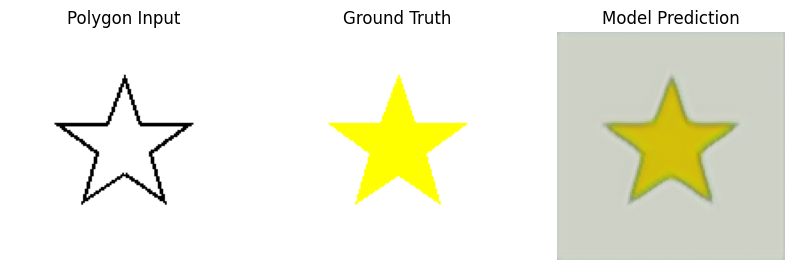

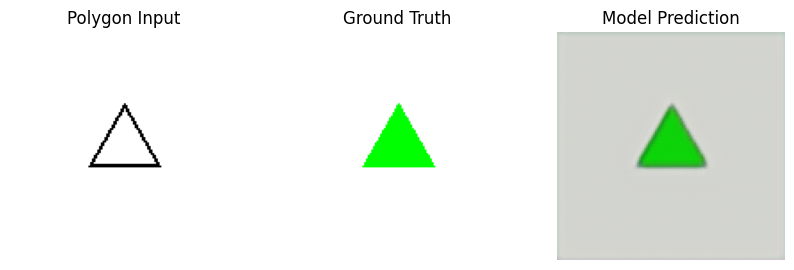

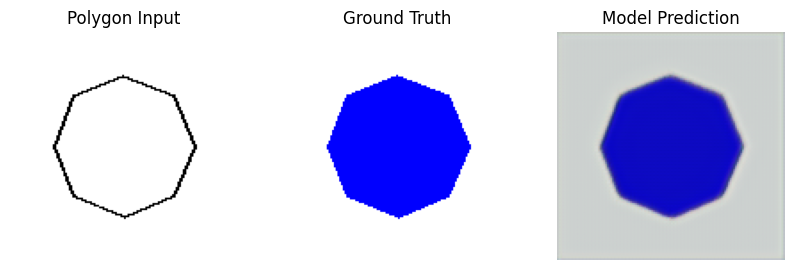

In [39]:
show_predictions(model, val_loader, device, num_images=3)
